`GAN` 은 Generator(생성자)와 Discriminator(식별자)를 adversarial하게 잘 학습시켜 기존의 데이터셋과 유사한 데이터를 생성하도록 하는 생성 모델이다.

생성자는 노이즈 벡터 z를 input으로 받아 기존의 데이텃세과 유사한 확률 분포를 가지는 데이터 샘플을 output으로 뽑아내는 녀석이다.

식별자는 실제 데이터셋에서 나온 Real Data와 생성자로부턴 나온 Fake Data 를 input으로 받아 이 둘을 최대한 real/fake로 classificatino하는 녀석이다.

아래는 논문에서 제안하는 adversarial network의 objective function (loss function)이다.

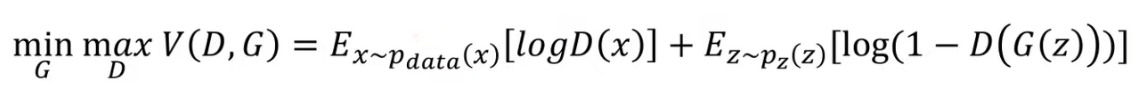

In [1]:
import os
import torch.nn as nn
import torch.utils.data
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [19]:
num_epoch = 200
batch_size = 100
learning_rate = 0.0002
img_size = 28 * 28
num_channel = 1
dir_name = "GAN_results"

noise_size = 100
hidden_size1 = 256
hidden_size2 = 512
hidden_size3 = 1024

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Now using {} devices".format(device))


if not os.path.exists(dir_name):
    os.makedirs(dir_name)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)])

MNIST_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True,
                                           transform=transform,
                                           download=True)

data_loader = torch.utils.data.DataLoader(dataset=MNIST_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

Now using cuda devices


In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.linear1 = nn.Linear(img_size, hidden_size3)
        self.linear2 = nn.Linear(hidden_size3, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size1)
        self.linear4 = nn.Linear(hidden_size1, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.linear1(x))
        x = self.leaky_relu(self.linear2(x))
        x = self.leaky_relu(self.linear3(x))
        x = self.linear4(x)
        x = self.sigmoid(x)
        return x

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.linear1 = nn.Linear(noise_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.linear4 = nn.Linear(hidden_size3, img_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        x = self.tanh(x)
        return x

In [22]:
discriminator = Discriminator()
generator = Generator()

discriminator = discriminator.to(device)
generator = generator.to(device)


In [23]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr = learning_rate)
g_optimizer = torch.optim.Adam(generator.parameters(), lr = learning_rate)


In [25]:
for epoch in range(num_epoch):
    for i, (images, label) in enumerate(data_loader):

        
        # 라벨을 만듬. 1 for real, 0 for fake
        real_label = torch.full((batch_size, 1), 1, dtype = torch.float32).to(device)
        fake_label = torch.full((batch_size, 1), 0, dtype = torch.float32).to(device)

        real_images = images.reshape(batch_size, -1).to(device)

        ######## 생성자 학습 ########
        # 기울기 초기화
        g_optimizer.zero_grad()
        d_optimizer.zero_grad()

        # fake image를 generator와 noize vector z를 통해 만들어줌
        z = torch.randn(batch_size, noise_size).to(device)
        fake_images = generator(z)

        # loss function에 fake image와 real label을 넘겨주기
        # 만약 generator가 discriminator를 속이면, g_loss가 줄어든다.
        g_loss = criterion(discriminator(fake_images), real_label)

        # backpropagation을 통해 생성자 학습
        g_loss.backward()
        g_optimizer.step()


        ######## 식별자 학습 ########
        
        # 기울기 초기화
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()

        # 생성자와 noise vector 'z'로 fake image 생성
        z = torch.randn(batch_size, noise_size).to(device)
        fake_images = generator(z)

        # fake image와 fake label, real image와 real label을 넘겨 loss 계산
        fake_loss = criterion(discriminator(fake_images), fake_label)
        real_loss = criterion(discriminator(real_images), real_label)
        d_loss = (fake_loss + real_loss) / 2

        # backpropagation을 통해 discriminator 학습
        # 이 부분에서는 generator는 학습시키지 않음
        d_loss.backward()
        d_optimizer.step()

        d_performance = discriminator(real_images).mean()
        g_performance = discriminator(fake_images).mean()

        if (i + 1) % 150 == 0:
            print("Epoch [ {}/{} ]  Step [ {}/{} ]  d_loss : {:.5f}  g_loss : {:.5f}"
                  .format(epoch, num_epoch, i+1, len(data_loader), d_loss.item(), g_loss.item()))
            
    # discriminator & generator's 성능 출력 
    print(" Epoch {}'s discriminator performance : {:.2f}  generator performance : {:.2f}"
          .format(epoch, d_performance, g_performance))

    # Save fake images
    samples = fake_images.reshape(batch_size, 1, 28, 28)
    save_image(samples, os.path.join(dir_name, 'GAN_fake_samples{}.png'.format(epoch + 1)))

Epoch [ 0/200 ]  Step [ 150/600 ]  d_loss : 0.00071  g_loss : 7.41780
Epoch [ 0/200 ]  Step [ 300/600 ]  d_loss : 0.01419  g_loss : 7.89678
Epoch [ 0/200 ]  Step [ 450/600 ]  d_loss : 0.04459  g_loss : 13.86161
Epoch [ 0/200 ]  Step [ 600/600 ]  d_loss : 0.00941  g_loss : 23.25723
 Epoch 0's discriminator performance : 1.00  generator performance : 0.00
Epoch [ 1/200 ]  Step [ 150/600 ]  d_loss : 0.59379  g_loss : 21.85641
Epoch [ 1/200 ]  Step [ 300/600 ]  d_loss : 0.06137  g_loss : 4.41547
Epoch [ 1/200 ]  Step [ 450/600 ]  d_loss : 0.26770  g_loss : 15.93152
Epoch [ 1/200 ]  Step [ 600/600 ]  d_loss : 0.17168  g_loss : 7.12787
 Epoch 1's discriminator performance : 0.91  generator performance : 0.00
Epoch [ 2/200 ]  Step [ 150/600 ]  d_loss : 0.49705  g_loss : 5.44883
Epoch [ 2/200 ]  Step [ 300/600 ]  d_loss : 0.06421  g_loss : 3.56981
Epoch [ 2/200 ]  Step [ 450/600 ]  d_loss : 1.22616  g_loss : 6.32983
Epoch [ 2/200 ]  Step [ 600/600 ]  d_loss : 0.27749  g_loss : 3.49703
 Epoch 2